# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

In [11]:
import pandas as pd
import numpy as np

import pymysql
from sqlalchemy import create_engine

import getpass  # To get the password without showing the input

In [12]:
password = getpass.getpass()

········


# Instructions

# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [202]:
query_x = """
SELECT
    f.film_id,
    f.title,
    f.release_year,
    f.language_id,
    f.rental_rate,
    f.rental_duration,
    f.length,
    f.rating,
    f.special_features
    
FROM
    film AS f

"""

data_x = pd.read_sql_query(query_x, engine)
data_x.head()

,film_id,title,release_year,language_id,rental_rate,rental_duration,length,rating,special_features
0,1,ACADEMY DINOSAUR,2006,1,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes"
1,2,ACE GOLDFINGER,2006,1,4.99,3,48,G,"Trailers,Deleted Scenes"
2,3,ADAPTATION HOLES,2006,1,2.99,7,50,NC-17,"Trailers,Deleted Scenes"
3,4,AFFAIR PREJUDICE,2006,1,2.99,5,117,G,"Commentaries,Behind the Scenes"
4,5,AFRICAN EGG,2006,1,2.99,6,130,G,Deleted Scenes


In [203]:
data_x.shape

(1000, 9)

# 2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [204]:
query_y = """
SELECT
    f.film_id,
    f.title,
    MAX(CASE WHEN r.rental_date BETWEEN '2005-05-01' AND '2005-05-31' THEN 1 ELSE 0 END) AS rented_in_may
FROM
    film AS f
LEFT JOIN
    inventory AS i ON f.film_id = i.film_id
LEFT JOIN
    rental AS r ON i.inventory_id = r.inventory_id
GROUP BY
    f.film_id, f.title
"""

data_y = pd.read_sql_query(query_y, engine)
data_y.head()


,film_id,title,rented_in_may
0,1,ACADEMY DINOSAUR,1
1,2,ACE GOLDFINGER,0
2,3,ADAPTATION HOLES,0
3,4,AFFAIR PREJUDICE,1
4,5,AFRICAN EGG,1


In [205]:
data_y.shape

(1000, 3)

# 3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [206]:
# Joining both dataframes to get a combined prediction column 
# as X dataframe is dimensional data about the films in store and y is about whether ever a film was rented or not

combined_data = pd.merge(data_x, data_y, how='left')
combined_data

,film_id,title,release_year,language_id,rental_rate,rental_duration,length,rating,special_features,rented_in_may
0,1,ACADEMY DINOSAUR,2006,1,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes",1
1,2,ACE GOLDFINGER,2006,1,4.99,3,48,G,"Trailers,Deleted Scenes",0
2,3,ADAPTATION HOLES,2006,1,2.99,7,50,NC-17,"Trailers,Deleted Scenes",0
3,4,AFFAIR PREJUDICE,2006,1,2.99,5,117,G,"Commentaries,Behind the Scenes",1
4,5,AFRICAN EGG,2006,1,2.99,6,130,G,Deleted Scenes,1
...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,2006,1,0.99,6,183,G,"Trailers,Behind the Scenes",0
996,997,YOUTH KICK,2006,1,0.99,4,179,NC-17,"Trailers,Behind the Scenes",0
997,998,ZHIVAGO CORE,2006,1,0.99,6,105,NC-17,Deleted Scenes,1
998,999,ZOOLANDER FICTION,2006,1,2.99,5,101,R,"Trailers,Deleted Scenes",1


In [207]:
# Checking distribution of yes and no values of whether a film was rented or not

combined_data.rented_in_may.value_counts()

1    627
0    373
Name: rented_in_may, dtype: int64

In [208]:
combined_data.language_id.value_counts()

1    1000
Name: language_id, dtype: int64

In [209]:
combined_data.release_year.value_counts()

2006    1000
Name: release_year, dtype: int64

# 4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [210]:
# Drop the columns that we do not need: 

X = combined_data.drop(columns=['film_id', 'title', 'language_id', 'rented_in_may', 'release_year'])
X

,rental_rate,rental_duration,length,rating,special_features
0,0.99,6,86,PG,"Deleted Scenes,Behind the Scenes"
1,4.99,3,48,G,"Trailers,Deleted Scenes"
2,2.99,7,50,NC-17,"Trailers,Deleted Scenes"
3,2.99,5,117,G,"Commentaries,Behind the Scenes"
4,2.99,6,130,G,Deleted Scenes
...,...,...,...,...,...
995,0.99,6,183,G,"Trailers,Behind the Scenes"
996,0.99,4,179,NC-17,"Trailers,Behind the Scenes"
997,0.99,6,105,NC-17,Deleted Scenes
998,2.99,5,101,R,"Trailers,Deleted Scenes"


In [211]:
X.dtypes

rental_rate         float64
rental_duration       int64
length                int64
rating               object
special_features     object
dtype: object

In [212]:
X.isna().sum()

rental_rate         0
rental_duration     0
length              0
rating              0
special_features    0
dtype: int64

In [213]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
rental_rate,1000.0,2.980,1.646393,0.99,0.99,2.99,4.99,4.99
rental_duration,1000.0,4.985,1.411654,3.00,4.00,5.00,6.00,7.00
length,1000.0,115.272,40.426332,46.00,80.00,114.00,149.25,185.00


In [228]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\simra\AppData\Local\Temp\ipykernel_15724\401046144.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=data.corr(method='pearson')  # default


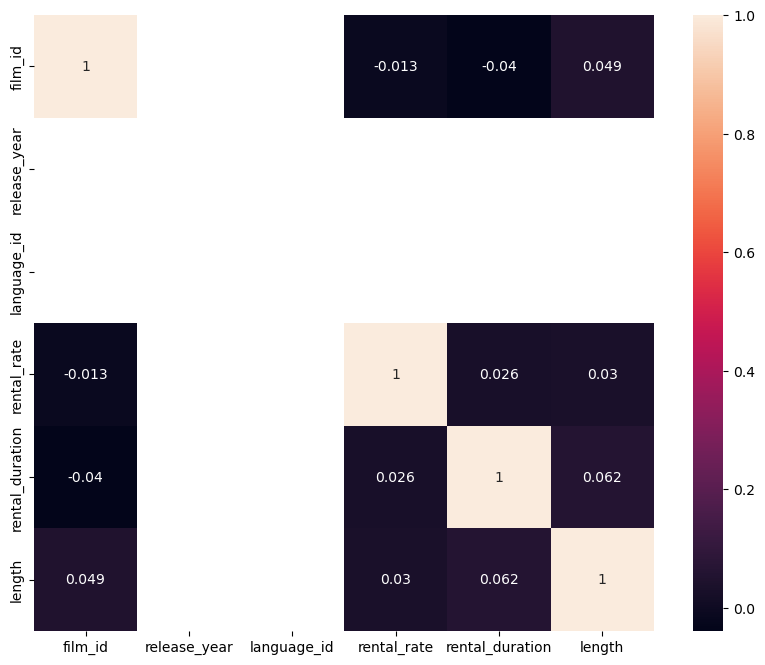

In [229]:
# look for multicolinearity (some columns having almost identical correlation to other variables)
# why can't we look for correlation with our target variable (status)?
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [230]:
def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df[col])
        plt.show()

#plot_distributions(data)
#sns.displot(data['l_amount'])
#plt.show()

#sns.displot(data['balance'])
#plt.show()

#sns.displot(data['payments'])
#plt.show()

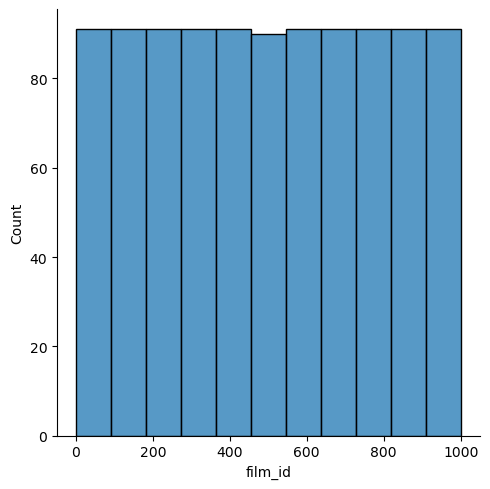

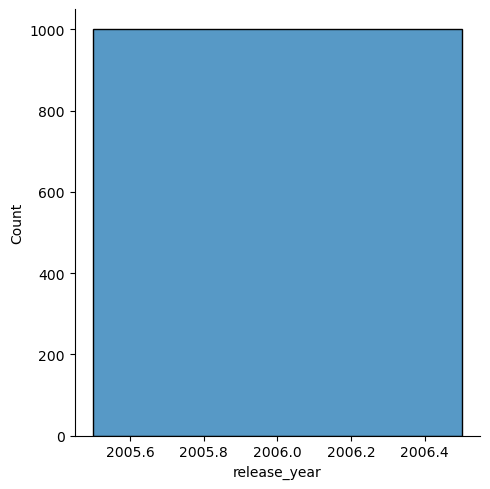

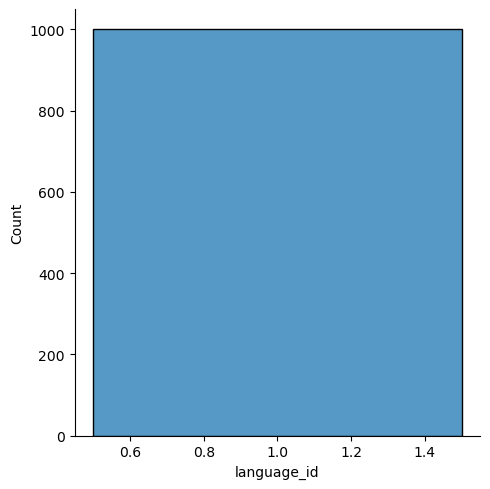

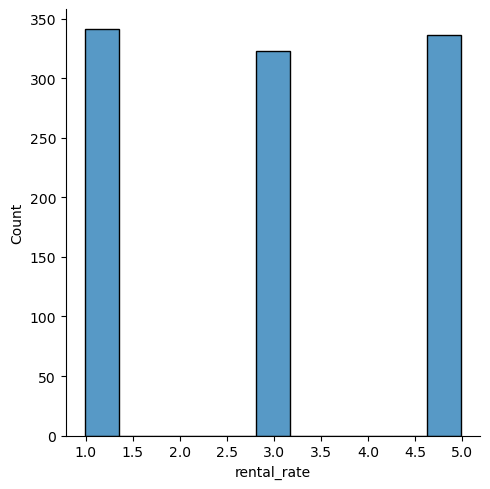

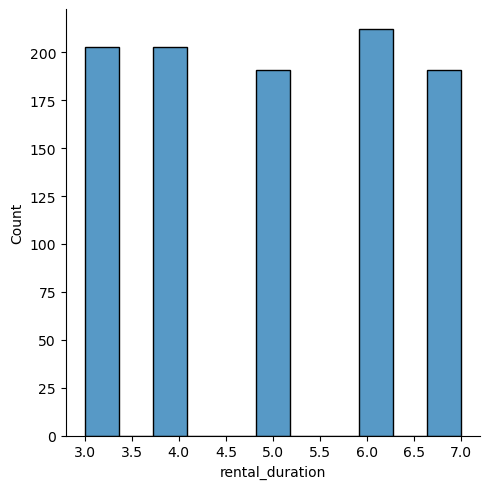

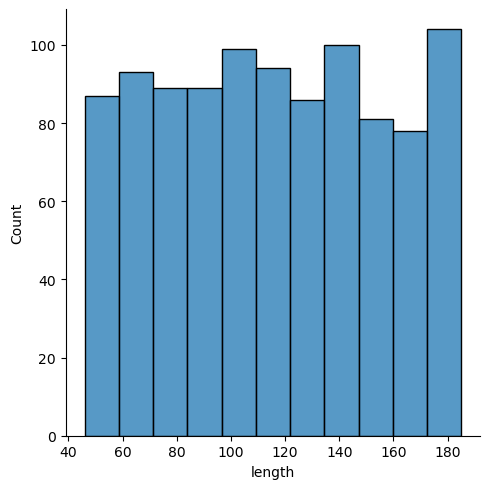

In [231]:
plot_distributions(data)

In [214]:
# One-hot encode the 'category_column'
X_encoded = pd.get_dummies(X, columns=['rating', 'special_features'])
X_encoded

,rental_rate,rental_duration,length,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.99,6,86,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,4.99,3,48,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.99,7,50,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2.99,5,117,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.99,6,130,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.99,6,183,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
996,0.99,4,179,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
997,0.99,6,105,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
998,2.99,5,101,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [215]:
y = combined_data.rented_in_may
y

0      1
1      0
2      0
3      1
4      1
      ..
995    0
996    0
997    1
998    1
999    1
Name: rented_in_may, Length: 1000, dtype: int64

# 5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [216]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [217]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [218]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns, index= X_train_num.index)
X_test_norm  = pd.DataFrame(X_test_normalized, columns=X_test_num.columns, index= X_test_num.index)

In [219]:
X_train_norm.describe()

,rental_rate,rental_duration,length,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.00000,800.00000,800.000000,800.000000,800.000000,800.000000
mean,0.499375,0.498437,0.493192,0.175000,0.212500,0.198750,0.223750,0.190000,0.068750,0.071250,...,0.070000,0.073750,0.075000,0.070000,0.06500,0.07750,0.062500,0.053750,0.068750,0.050000
std,0.412189,0.356524,0.292183,0.380205,0.409333,0.399309,0.417017,0.392546,0.253187,0.257403,...,0.255307,0.261527,0.263556,0.255307,0.24668,0.26755,0.242213,0.225665,0.253187,0.218081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.237410,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.482014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.750000,0.735612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


In [220]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,rental_rate,rental_duration,length,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
29,0.5,0.25,0.258993,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
535,0.5,0.00,0.136691,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.75,0.489209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,0.5,0.00,0.179856,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
836,0.5,0.25,0.280576,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
X_train_categorical = X_train.select_dtypes('object')
X_test_categorical  = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder

#categories_values = [list(data[col].unique()) for col in X_train_categorical.columns]
encoder = OneHotEncoder(drop='first') 
encoder.fit(X_train_categorical)

X_train_cat_np = encoder.transform(X_train_categorical).toarray()
X_test_cat_np  = encoder.transform(X_test_categorical).toarray()

X_train_cat = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out(), 
                           index=X_train_categorical.index)
X_test_cat  = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out(),
                          index=X_test_categorical.index)

#X_train_cat = pd.get_dummies(X_train_categorical, 
#                             columns=['type', 'operation', 'k_symbol', 'duration'],
#                             drop_first=True)
#X_test_cat = pd.get_dummies(X_test_categorical, 
#                             columns=['type', 'operation', 'k_symbol', 'duration'],
#                             drop_first=True)

X_train_cat.head()

""
29
535
695
557
836


In [222]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = pd.concat([X_train_norm, X_train_cat], axis=1)

In [223]:
X_train_transformed

,rental_rate,rental_duration,length,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,special_features_Commentaries,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
29,0.5,0.25,0.258993,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
535,0.5,0.00,0.136691,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.75,0.489209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,0.5,0.00,0.179856,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
836,0.5,0.25,0.280576,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.5,0.25,0.122302,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,1.0,0.50,0.733813,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
860,1.0,0.00,0.467626,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,0.0,0.25,0.546763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [224]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [225]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial')

classification.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

# 6. Evaluate the results.

In [201]:
# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

NameError: name 'accuracy_score' is not defined